In [1]:
from utils import *
from DL_ClassifierModel import *
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import cv2
import os,torch
# import seaborn as sns

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
torch.cuda.device_count()

0

In [3]:
# 读取数据
# dataClass = DataClass_multi_output('../DataSet/', 'Data/train.txt', 'Data/test.txt', 'Data/vocabulary_agnostic.txt', hs=128, dropBLANK=True)
dataClass = DataClass_multi_output('../MiniData/', 'Data/Mtrain.txt', 'Data/Mtest.txt', 'Data/vocabulary_agnostic.txt', hs=128, dropBLANK=True)


Loading files...
Openning images...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:07<00:00, 156.86it/s]


Converting images...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 304.60it/s]


Finishing...


In [6]:
# 建立模型
model = Trans2trans_multi_output(   classNum1=dataClass.classNum1, classNum2=dataClass.classNum2, 
                                    labType2id=dataClass.labType2id, id2labType=dataClass.id2labType, labLoc2id=dataClass.labLoc2id, id2labLoc=dataClass.id2labLoc, 
                                    lab12id=dataClass.lab12id, id2lab1=dataClass.id2lab1,
                                    seqMaxLen=dataClass.maxItems*4+1+dataClass.maxItems+1,
                                    tknDropout=0.1, embDropout=0.0, hdnDropout=0.1, fcDropout=0.0,
                                    imgHeight=128, contextSizeList=[1,5,25,49], feaSize=1024, rnnLayerNum=2,
                                    transNum=4, dk=48, multiNum=8, usePos=True, usePreLN=True,
                                    maxItems=dataClass.maxItems, device=torch.device('cpu'))

In [7]:
model.train(dataClass, trainSize=16, batchSize=16, validSize=64, epoch=128, stopRounds=-1, earlyStop=20, saveRounds=1, 
            optimType='Adam', preheat=0, lr1=0.0001, lr2=0.01, weightDecay=0, isHigherBetter=False, metrics="editDistDivSeq", report=["seqErrorDivSeq", "editDistDivSeq", "editDistDivSymbol"], 
            savePath='TrainModel_splitAgnostic')

Start pre-heat training:
Start normal training: 


Epoch 0: training loss - 8.310:   2%|▊                                               | 1/57 [02:57<2:46:00, 177.87s/it]


KeyboardInterrupt: 

In [67]:
model.to_eval_mode()

In [68]:
model.load('trainAgnosticModel_multi_output.pkl', map_location="cuda")

274 epochs and 0.132 val Score 's model load finished.


In [60]:
def one_image_predict(imgArr):
    imgArr = torch.tensor([imgArr], dtype=torch.float32, device=model.device).transpose(1,2)
    imgLab = torch.cat([torch.tensor([[[2,2]]],device=model.device),torch.zeros((1,model.maxItems+1,2), dtype=torch.long, device=model.device)], dim=1)
    #imgLab_type = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
    #imgLab_loc = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
    cnt = 1
    x = torch.cat(model.seqCNN(imgArr), dim=-1)
    x_pool = F.adaptive_max_pool1d(x.transpose(1,2), model.maxItems*4).transpose(1,2)
    while True:
        imgLab_type = imgLab[:,:,0]
        imgLab_loc = imgLab[:,:,1]
        
        y1 = model.symEmbedding1(imgLab_type)
        y2 = model.symEmbedding2(imgLab_loc)
        y = y1 + y2
        # x_pool: 1 × seqLen × feaSize
        B,L,C = x_pool.shape
        x_rnn, hn = model.eSeqRNN(torch.cat([x_pool,y[:,:1]], dim=1)) # => batchSize × seqLen × hiddenSize*2
        eos = x_rnn[:,-1:]
        x_rnn = x_rnn[:,:-1]
        x = x_rnn + x_pool
        x = torch.cat([x, eos], dim=1)
        if type(hn)==tuple:
            hn,cn = hn
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            cn = hn.view(model.rnnLayerNum, 2, B, C//2)
            cn = torch.cat([cn[:,0],cn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            hn = (hn,cn)
        else:
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2x = torch.cat([x, eos], dim=1)
        y, _ = model.dSeqRNN(y[:,1:], h0=hn) # => batchSize × seqLen × hiddenSize*2
        x = torch.cat([x,y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        if torch.cuda.device_count() > 1:
            x,_ = nn.parallel.data_parallel(model.transformer,x)
        else:
            x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        y = x[:,-model.maxItems-2:-1]
        y = model.fcLinear(F.relu(y)) # => 1 × (maxItems+1) × classNum
        
        yp1,yp2 = y[:,:,:model.classNum1],y[:,:,model.classNum1:]
        
        
        y = torch.cat([torch.tensor([[[2,2]]], device=model.device),torch.cat([yp1.argmax(dim=-1,keepdim=True),yp2.argmax(dim=-1,keepdim=True)],dim=-1)], dim=1) # => 1 × (maxItems+1)

        imgLab = torch.tensor(y, dtype=torch.long, device=model.device)

        if cnt>model.maxItems or y[0,cnt,0]==1 or y[0,cnt,1]==1:
            break
        cnt += 1    
    Y_pre = imgLab
    Y_pre = [[(model.id2labType[j[0]]+'-'+model.id2labLoc[j[1]]).replace('<EOS>-<EOS>', '<EOS>').replace('<PAD>-<PAD>', '<PAD>').replace('<SOS>-<SOS>', '<SOS>') for j in i] for i in Y_pre]
    Y_pre = np.array([[model.lab12id[j] if j in model.lab12id else -1 for j in i] for i in Y_pre], dtype='int32')
    
    return Y_pre[0].tolist()

In [66]:
# i = dataClass.imgArr[dataClass.testIdList[0]]-0.5
# yp = one_image_predict(i)
# print(yp)
# yt = dataClass.labArr[dataClass.testIdList[0]]
# print(yt)
#单预测
ypreList = []
for i in range(DataClass.testIdList):
    imgArr = dataClass.imgArr[i]-0.5
    yp = one_image_predict(imgArr)
    ypreList.append(yp[:yp.index(1)] if 1 in yp else yp)

SyntaxError: unexpected EOF while parsing (<ipython-input-66-3f64053b5317>, line 7)

In [69]:
def batch_image_predict(batchImgArr):
    imgArr = torch.tensor(imgArr, dtype=torch.float32, device=model.device).transpose(1,2)
    imgLab = torch.cat([torch.tensor([[[2,2]]],device=model.device),torch.zeros((1,model.maxItems+1,2), dtype=torch.long, device=model.device)], dim=1)
    #imgLab_type = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
    #imgLab_loc = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
    cnt = 1
    x = torch.cat(model.seqCNN(imgArr), dim=-1)
    x_pool = F.adaptive_max_pool1d(x.transpose(1,2), model.maxItems*4).transpose(1,2)
    while True:
        imgLab_type = imgLab[:,:,0]
        imgLab_loc = imgLab[:,:,1]
        
        y1 = model.symEmbedding1(imgLab_type)
        y2 = model.symEmbedding2(imgLab_loc)
        y = y1 + y2
        # x_pool: 1 × seqLen × feaSize
        B,L,C = x_pool.shape
        x_rnn, hn = model.eSeqRNN(torch.cat([x_pool,y[:,:1]], dim=1)) # => batchSize × seqLen × hiddenSize*2
        eos = x_rnn[:,-1:]
        x_rnn = x_rnn[:,:-1]
        x = x_rnn + x_pool
        x = torch.cat([x, eos], dim=1)
        if type(hn)==tuple:
            hn,cn = hn
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            cn = hn.view(model.rnnLayerNum, 2, B, C//2)
            cn = torch.cat([cn[:,0],cn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            hn = (hn,cn)
        else:
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2x = torch.cat([x, eos], dim=1)
        y, _ = model.dSeqRNN(y[:,1:], h0=hn) # => batchSize × seqLen × hiddenSize*2
        x = torch.cat([x,y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        if torch.cuda.device_count() > 1:
            x,_ = nn.parallel.data_parallel(model.transformer,x)
        else:
            x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        y = x[:,-model.maxItems-2:-1]
        y = model.fcLinear(F.relu(y)) # => 1 × (maxItems+1) × classNum
        
        yp1,yp2 = y[:,:,:model.classNum1],y[:,:,model.classNum1:]
        
        
        y = torch.cat([torch.tensor([[[2,2]]], device=model.device),torch.cat([yp1.argmax(dim=-1,keepdim=True),yp2.argmax(dim=-1,keepdim=True)],dim=-1)], dim=1) # => 1 × (maxItems+1)

        imgLab = torch.tensor(y, dtype=torch.long, device=model.device)

        if cnt>model.maxItems or y[0,cnt,0]==1 or y[0,cnt,1]==1:
            break
        cnt += 1    
    Y_pre = imgLab
    Y_pre = [[(model.id2labType[j[0]]+'-'+model.id2labLoc[j[1]]).replace('<EOS>-<EOS>', '<EOS>').replace('<PAD>-<PAD>', '<PAD>').replace('<SOS>-<SOS>', '<SOS>') for j in i] for i in Y_pre]
    Y_pre = np.array([[model.lab12id[j] if j in model.lab12id else -1 for j in i] for i in Y_pre], dtype='int32')
    
    return Y_pre[0].tolist()

In [70]:
# i = dataClass.imgArr[dataClass.testIdList[:10]]-0.5
# yp = batch_image_predict(i)
# print(yp)
# yt = dataClass.labArr[dataClass.testIdList[:10]]
# print(yt)
#批预测
bs = 128
ypreList = []
for i in tqdm(range((len(dataClass.testIdList)+bs-1)//(bs))):
    samples = dataClass.testIdList[i*bs:(i+1)*bs]
    imgArr = dataClass.imgArr[samples]-0.5
    yps = batch_image_predict(imgArr)
    for yp in yps:
        ypreList.append(yp[:yp.index(1)] if 1 in yp else yp)

100%|██████████| 70/70 [14:51<00:00, 12.74s/it]


In [10]:
dataClass.imgArr[dataClass.testIdList[0]]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [11]:
dataClass.labArr[dataClass.testIdList[0]]

array([   2,    4,  232, 1754,  268,    3, 1730, 1720,  681,    3,  691,
       1602,    3, 1317, 1021,    3,  826,  826, 1730,    3,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [9]:
idx = 45

In [9]:
ypreList = []
for i in tqdm(dataClass.testIdList):
    
    imgArr = dataClass.imgArr[i]-0.5
    imgArr = torch.tensor([imgArr], dtype=torch.float32, device=model.device).transpose(1,2)
    imgLab = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
    cnt = 1
        
    while True:
        x = torch.cat(model.seqCNN(imgArr), dim=-1)
        x_pool = F.adaptive_max_pool1d(x.transpose(1,2), model.maxItems*4).transpose(1,2)
        y = model.symEmbedding(imgLab)
        # x_pool: 1 × seqLen × feaSize
        B,L,C = x_pool.shape
        x_rnn, hn = model.eSeqRNN(torch.cat([x_pool,y[:,:1]], dim=1)) # => batchSize × seqLen × hiddenSize*2
        eos = x_rnn[:,-1:]
        x_rnn = x_rnn[:,:-1]
        x = x_rnn + x_pool
        x = torch.cat([x, eos], dim=1)
        if type(hn)==tuple:
            hn,cn = hn
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            cn = hn.view(model.rnnLayerNum, 2, B, C//2)
            cn = torch.cat([cn[:,0],cn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2
            hn = (hn,cn)
        else:
            hn = hn.view(model.rnnLayerNum, 2, B, C//2)
            hn = torch.cat([hn[:,0],hn[:,1]], dim=2) # => numLayers × batchSize × hiddenSize*2x = torch.cat([x, eos], dim=1)
        y, _ = model.dSeqRNN(y[:,1:], h0=hn) # => batchSize × seqLen × hiddenSize*2
        x = torch.cat([x,y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        if torch.cuda.device_count() > 1:
            x,_ = nn.parallel.data_parallel(model.transformer,x)
        else:
            x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
        y = x[:,-model.maxItems-2:-1]
        y = model.fcLinear(F.relu(y)) # => 1 × (maxItems+1) × classNum

        y = torch.cat([torch.tensor([[2]], device=model.device),y.argmax(dim=-1)], dim=1) # => 1 × (maxItems+1)
        imgLab = torch.tensor(y, dtype=torch.long, device=model.device)
        if cnt>model.maxItems or y[0,cnt]==1:
            break
        cnt += 1    
    yp = imgLab.tolist()[0]
    ypreList.append(yp[:yp.index(1)] if 1 in yp else yp)

100%|██████████| 8923/8923 [4:27:12<00:00,  1.80s/it]  


In [9]:
print( type(ypreList) )
print(ypreList)

<class 'list'>
[[2, 4, 232, 1754, 268, 3, 1730, 1720, 681, 3, 691, 1602, 3, 1317, 1021, 3, 826, 826, 1730, 3], [2, 4, 226, 1782, 269, 3, 1725, 1730, 1720, 1408, 3, 685, 1744, 690, 1306, 1021, 3, 1030, 1649, 1457, 3, 1457, 1021, 690, 1725, 3], [2, 7, 1782, 325, 3, 1730, 1720, 1584, 1584, 1577, 1562, 369, 3, 554, 554, 1720, 554, 979, 979, 777, 979, 3, 564, 564, 1720, 554, 369, 554, 3], [2, 13, 231, 1754, 1736, 1436, 1628, 429, 979, 1021, 1744, 3, 1021, 854, 607, 854, 1047, 1213, 1744, 3, 1235, 429, 607, 854], [2, 4, 234, 1782, 317, 3, 437, 3, 411, 411, 3, 1609, 411, 3, 1415, 986, 3, 995], [2, 4, 1782, 1720, 777, 1177, 405, 1744, 405, 1620, 1436, 1197, 3, 1442, 1636, 433, 613, 826, 1744, 826, 607, 429, 607, 1628, 1191, 1003, 805, 3, 979, 1720], [2, 13, 224, 1782, 1725, 1656, 1744, 3, 1666, 1473, 708, 1744, 3, 711, 456, 1126, 1744, 3, 1127, 875, 705, 456, 889, 1744, 3, 889], [2, 13, 224, 1782, 243, 3, 1725, 1609, 1744, 3, 1620, 1429, 685, 1744, 3, 690, 500, 1111, 1744, 3, 1114, 826, 681, 4

In [71]:
yList = []
for i in dataClass.testIdList:
    y = dataClass.labArr[i].tolist()
    yList.append(y[:y.index(1)])

In [11]:
print( type(yList) )
print(yList)

<class 'list'>
[[2, 4, 232, 1754, 268, 3, 1730, 1720, 681, 3, 691, 1602, 3, 1317, 1021, 3, 826, 826, 1730, 3], [2, 4, 226, 1782, 269, 3, 1725, 1730, 1720, 1408, 3, 685, 1744, 690, 1306, 1021, 3, 1030, 1649, 1457, 3, 1457, 1021, 690, 1725, 3], [2, 7, 1782, 325, 3, 1730, 1720, 1584, 1584, 1577, 1562, 369, 3, 554, 554, 1720, 554, 979, 979, 777, 979, 3, 564, 564, 1720, 554, 369, 554, 3], [2, 13, 231, 1754, 1736, 1436, 1628, 429, 979, 1021, 1744, 3, 1021, 854, 607, 854, 1047, 1213, 1744, 3, 1235, 429, 607, 854], [2, 4, 234, 1782, 317, 3, 437, 3, 411, 411, 3, 1609, 411, 3, 1415, 986, 3, 995], [2, 4, 1782, 1720, 777, 1177, 405, 405, 1620, 1436, 1197, 3, 1442, 1636, 433, 613, 826, 1744, 826, 607, 429, 607, 1628, 1191, 1003, 805, 3, 979, 1720], [2, 13, 224, 1782, 1725, 1656, 1744, 3, 1666, 1473, 708, 1744, 3, 711, 518, 1126, 1744, 3, 1127, 875, 705, 456, 889, 1744, 3, 889], [2, 13, 224, 1782, 243, 3, 1725, 1609, 1744, 3, 1620, 1429, 685, 1744, 3, 690, 500, 1111, 1744, 3, 1114, 826, 681, 411, 3,

In [81]:
def levenshtein(a,b):
    "Computes the Levenshtein distance between a and b."
    n, m = len(a), len(b)

    if n > m:
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]


def edit_distance(a,b,EOS=1,PAD=1):
    _a = [s for s in a if s != EOS and s != PAD]
    _b = [s for s in b if s != EOS and s != PAD]

    return levenshtein(_a,_b)

In [1]:
seqError = 0
seqNum = 0
editDistance = 0
symbolNum = 0
for yp,yt in zip(ypreList, yList):
    yp_len, yt_len = len(yp), len(yt)
    yp_loc, yt_loc = yp.index(1) if 1 in yp else yp_len, yt.index(1) if 1 in yt else yt_len
    yp, yt = yp[:yp_loc], yt[:yt_loc]
    if len(yp) == len(yt):
        if yp == yt:
            seqError += 1
    edit_dist = edit_distance(yp, yt)
    editDistance += edit_dist
    symbolNum += len(yt)
    seqNum += 1
    
print(seqError, '  ', editDistance, '  ', seqNum, '  ', symbolNum)
print('seqError/seqNum = ',1-seqError/seqNum)
print('editDistance/seqNum = ',editDistance/seqNum)
print('editDistance/symbolNum=',editDistance/symbolNum)

NameError: name 'ypreList' is not defined

In [86]:
def seqErrorDivSeq(Y_pre, Y):
    seqError = 0
    for yp, yt in zip(Y_pre, Y):
        l = len(yt)
        i1,i2 = yp.index(1) if 1 in yp else len(yp), yt.index(1) if 1 in yt else len(yt)
        yp,yt = yp[:i1],yt[:i2]
        if len(yp)==len(yt):
            if yp==yt:
                seqError += 1
    print(seqError, len(Y))
    return 1-seqError / len(Y)
def editDistDivSeq(Y_pre, Y):
    editDist = 0
    for yp, yt in zip(Y_pre, Y):
        l = len(yt)
        i1,i2 = min(yp.index(1) if 1 in yp else l, yp.index(0) if 0 in yp else l),min(yt.index(1) if 1 in yt else l,yt.index(0) if 0 in yt else l)
        yp,yt = yp[:i1],yt[:i2]
        editDist += edit_distance(yp, yt)
    print(editDist, len(Y))
    return editDist / len(Y)
def editDistDivSymbol(Y_pre, Y):
    editDist = 0
    allSymbol = 0
    for yp, yt in zip(Y_pre, Y):
        l = len(yt)
        i1,i2 = min(yp.index(1) if 1 in yp else l, yp.index(0) if 0 in yp else l),min(yt.index(1) if 1 in yt else l,yt.index(0) if 0 in yt else l)
        yp,yt = yp[:i1],yt[:i2]
        editDist += edit_distance(yp, yt)
        allSymbol += len(yt)
    print(editDist, allSymbol)
    return editDist / allSymbol


print( seqErrorDivSeq(ypreList, yList) )
print( editDistDivSeq(ypreList, yList) )
print( editDistDivSymbol(ypreList, yList) )

8284 8923
0.07161268631626139
1590 8923
0.1781911913033733
1590 254897
0.006237813705143647


In [22]:
# ypreList[0]

[2,
 4,
 1754,
 268,
 3,
 1730,
 1720,
 681,
 3,
 691,
 1602,
 3,
 1229,
 1021,
 3,
 826,
 826,
 1730,
 3]

In [23]:
# yList[0]

[2,
 4,
 232,
 1754,
 268,
 3,
 1730,
 1720,
 681,
 3,
 691,
 1602,
 3,
 1317,
 1021,
 3,
 826,
 826,
 1730,
 3,
 1]

In [39]:
[dataClass.id2lab1]

[['<PAD>',
  '<EOS>',
  '<SOS>',
  'accidental.flat-L0',
  'accidental.flat-L1',
  'accidental.flat-L-1',
  'accidental.flat-L2',
  'accidental.flat-L3',
  'accidental.flat-L4',
  'accidental.flat-L5',
  'accidental.flat-L6',
  'accidental.flat-L7',
  'accidental.flat-L8',
  'accidental.flat-S0',
  'accidental.flat-S1',
  'accidental.flat-S-1',
  'accidental.flat-S2',
  'accidental.flat-S-2',
  'accidental.flat-S3',
  'accidental.flat-S4',
  'accidental.flat-S5',
  'accidental.flat-S6',
  'accidental.flat-S7',
  'accidental.natural-L0',
  'accidental.natural-L1',
  'accidental.natural-L-1',
  'accidental.natural-L2',
  'accidental.natural-L-2',
  'accidental.natural-L3',
  'accidental.natural-L4',
  'accidental.natural-L5',
  'accidental.natural-L6',
  'accidental.natural-L7',
  'accidental.natural-L8',
  'accidental.natural-S0',
  'accidental.natural-S1',
  'accidental.natural-S-1',
  'accidental.natural-S2',
  'accidental.natural-S-2',
  'accidental.natural-S3',
  'accidental.natural

In [43]:
imgArr = dataClass.imgArr[dataClass.testIdList[idx]]
imgArr = torch.tensor([imgArr], dtype=torch.float32, device=model.device).transpose(1,2)
imgLab = torch.cat([torch.tensor([[2]],device=model.device),torch.zeros((1,model.maxItems+1), dtype=torch.long, device=model.device)], dim=1)
#imgLab = torch.tensor([dataClass.labArr[dataClass.trainIdList[idx]]], device=model.device, dtype=torch.long)
# imgArr: 1 × seqLen × feaSize
B,L,C = imgArr.shape
cnt = 1
print(imgLab)
while True:
    x = torch.cat(model.seqCNN(imgArr), dim=-1)
    x = F.adaptive_avg_pool1d(x.transpose(1,2), model.maxItems*4).transpose(1,2)
    y = model.symEmbedding(imgLab)
    x = model.eSeqRNN(torch.cat([x,y[:,:1]], dim=1)) # => batchSize × seqLen × hiddenSize*2
    y = model.dSeqRNN(y[:,1:]) # => batchSize × seqLen × hiddenSize*2
    
    x = torch.cat([x,y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
    x,_ = model.transformer(x)
    y = x[:,-model.maxItems-2:-1]
    y = model.fcLinear(F.relu(y)) # => 1 × (maxItems+1) × classNum
    #print(y.argmax(dim=-1))

    y = torch.cat([torch.tensor([[2]], device=model.device),y.argmax(dim=-1)], dim=1) # => 1 × (maxItems+1)
    print(y[0,:cnt+1])
    imgLab = torch.tensor(y, dtype=torch.long, device=model.device)
    if cnt>model.maxItems or y[0,cnt]==1:
        break
    cnt += 1

tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
tensor([ 2, 10], device='cuda:0')
tensor([  2,  10, 232], device='cuda:0')
tensor([   2,   10,  232, 1782], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642, 1720], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3], device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3, 1720],
       device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3, 1720, 1277],
       device='cuda:0')
tensor([   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3, 1720, 1277, 1584],
       device='cuda:0')
tensor([   2

In [44]:
imgLab

tensor([[   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3, 1720, 1277, 1584,
          658, 1562, 1720, 1277, 1584,  658, 1268,    3,    1,    1,    1,    1,
            3, 1720, 1277, 1584,  658, 1562, 1720, 1277, 1584,  658, 1268,    3,
            1,    1,    3,    1,    1,    1,    1,    1,    1,    3,    3,  671,
         1584,  658, 1562, 1720, 1277, 1584,  658,  671, 1277,    3,    1,    1]],
       device='cuda:0')

In [45]:
dataClass.labArr[dataClass.testIdList[idx]]

array([   2,   10,  232, 1782, 1268, 1720,  642, 1720,    3, 1720, 1277,
       1584,  658, 1562, 1720, 1277, 1584,  658, 1268,    3,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [46]:
imgArr.shape

torch.Size([1, 1104, 64])

In [47]:
dataClass.maxItems*4+1,dataClass.maxItems+1

(233, 59)

In [48]:
imgArr[0].shape

torch.Size([1104, 64])

In [ ]:
plt.imshow( imgArr[0].transpose(0,1).cpu() )

In [50]:
imgArr[0].transpose(0,1).shape

torch.Size([64, 1104])

In [51]:
dataClass.maxItems*4

232

In [66]:
1104/232

4.758620689655173

In [53]:
scores.shape

NameError: name 'scores' is not defined

In [70]:
232*4.76

1104.32

In [54]:
multi_scores = model.transformer.transformerLayers.transformer0.selfAttn.scores

In [71]:
multi_scores[0][233:, :-60].shape

torch.Size([0, 232, 292])

In [98]:
alphas = []
scores = multi_scores[2][0].detach()
for score in scores[233:,:-60]:
    alpha = torch.zeros((10,1104), dtype=torch.float32)
    for i,s in enumerate(score):
        alpha[:,int(i*4.76):int((i+1)*4.76)+1] = s
    alpha /= alpha.sum()/10
    alphas.append(alpha)

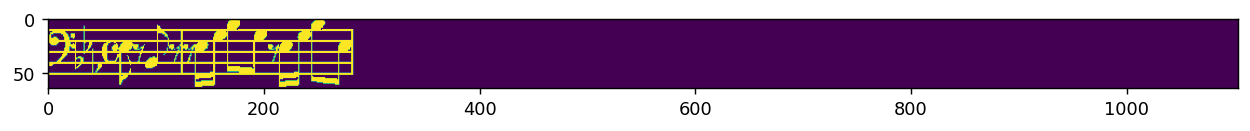

In [84]:
plt.figure(figsize=(12,4), dpi=128)
plt.imshow( imgArr[0].transpose(0,1).cpu() )

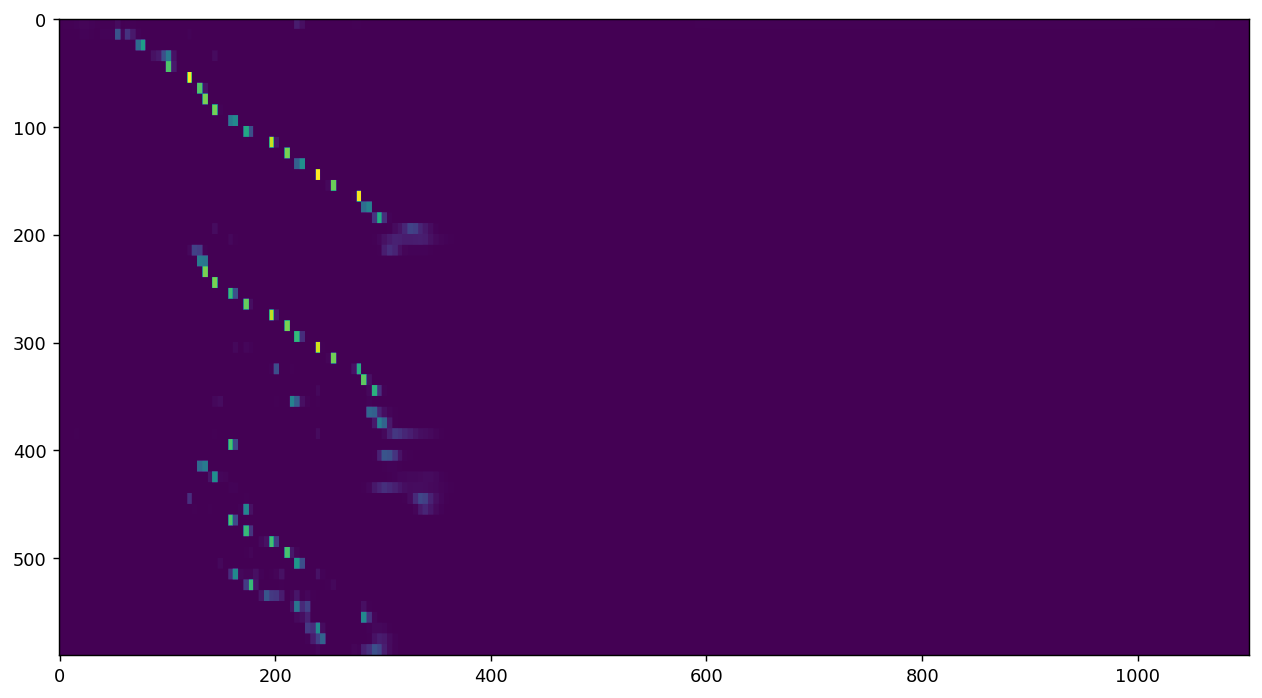

In [99]:
plt.figure(figsize=(12,40), dpi=128)
plt.imshow( np.vstack(alphas) )
_ = plt.yticks([i*pix+pix//2 for i in range(60)], [i for i in imgLab[0].detach().cpu().numpy()], rotation=0)

In [ ]:
grid = plt.GridSpec(10,5, wspace=0.0, hspace=0.0)
plt.figure(figsize=(12,12), dpi=128)
plt.subplot(grid[0,:4],)
plt.axis('off')
plt.imshow( imgArr[0].cpu().transpose(0,1), cmap='Greens') ##Blues、Greens、
plt.subplot(grid[1:,:])
sns.heatmap(np.vstack(alphas))
#plt.imshow( np.vstack(alphas) )
_ = plt.yticks([i*pix+pix//2 for i in range(60)], [dataClass.id2lab2[i] for i in imgLab[0].detach().cpu().numpy()], rotation=0)
_ = plt.xticks([])

In [79]:
print( len( dataClass.id2lab1 ) )
print( len( dataClass.id2lab2 ) )

761
1784


In [100]:
from sklearn.manifold import TSNE

In [218]:
help(TSNE)

Help on class TSNE in module sklearn.manifold._t_sne:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
 |  
 |  t-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |  to reduce the number of dimen

In [101]:
sysEmb = model.symEmbedding.embedding.weight.detach().cpu().numpy()
tsne=TSNE(n_components=2, init='pca', n_jobs=-1, random_state=10086, n_iter=2048)
sysEmb = tsne.fit_transform(sysEmb)

In [217]:
dataClass.id2lab1

['<PAD>',
 '<EOS>',
 '<SOS>',
 'accidental.flat-L0',
 'accidental.flat-L1',
 'accidental.flat-L-1',
 'accidental.flat-L2',
 'accidental.flat-L3',
 'accidental.flat-L4',
 'accidental.flat-L5',
 'accidental.flat-L6',
 'accidental.flat-L7',
 'accidental.flat-L8',
 'accidental.flat-S0',
 'accidental.flat-S1',
 'accidental.flat-S-1',
 'accidental.flat-S2',
 'accidental.flat-S-2',
 'accidental.flat-S3',
 'accidental.flat-S4',
 'accidental.flat-S5',
 'accidental.flat-S6',
 'accidental.flat-S7',
 'accidental.natural-L0',
 'accidental.natural-L1',
 'accidental.natural-L-1',
 'accidental.natural-L2',
 'accidental.natural-L-2',
 'accidental.natural-L3',
 'accidental.natural-L4',
 'accidental.natural-L5',
 'accidental.natural-L6',
 'accidental.natural-L7',
 'accidental.natural-L8',
 'accidental.natural-S0',
 'accidental.natural-S1',
 'accidental.natural-S-1',
 'accidental.natural-S2',
 'accidental.natural-S-2',
 'accidental.natural-S3',
 'accidental.natural-S-3',
 'accidental.natural-S4',
 'accide

In [223]:
dataClass.id2lab2

['<PAD>',
 '<EOS>',
 '<SOS>',
 'barline',
 'clef-C1',
 'clef-C2',
 'clef-C3',
 'clef-C4',
 'clef-C5',
 'clef-F3',
 'clef-F4',
 'clef-F5',
 'clef-G1',
 'clef-G2',
 'gracenote-A2_eighth',
 'gracenote-A2_quarter',
 'gracenote-A2_sixteenth',
 'gracenote-A#3_eighth',
 'gracenote-A3_eighth',
 'gracenote-A3_half',
 'gracenote-A3_quarter',
 'gracenote-A#3_sixteenth',
 'gracenote-A3_sixteenth',
 'gracenote-A3_thirty_second',
 'gracenote-A#4_eighth',
 'gracenote-A4_eighth',
 'gracenote-A#4_half',
 'gracenote-A4_half',
 'gracenote-A#4_quarter',
 'gracenote-A4_quarter',
 'gracenote-A#4_sixteenth',
 'gracenote-A4_sixteenth',
 'gracenote-A#4_thirty_second',
 'gracenote-A4_thirty_second',
 'gracenote-A#5_eighth',
 'gracenote-A5_eighth',
 'gracenote-A5_quarter',
 'gracenote-A5_sixteenth',
 'gracenote-A5_sixteenth.',
 'gracenote-A5_thirty_second',
 'gracenote-Ab3_double_whole',
 'gracenote-Ab3_eighth',
 'gracenote-Ab3_sixteenth',
 'gracenote-Ab3_thirty_second',
 'gracenote-Ab4_eighth',
 'gracenote-Ab4_

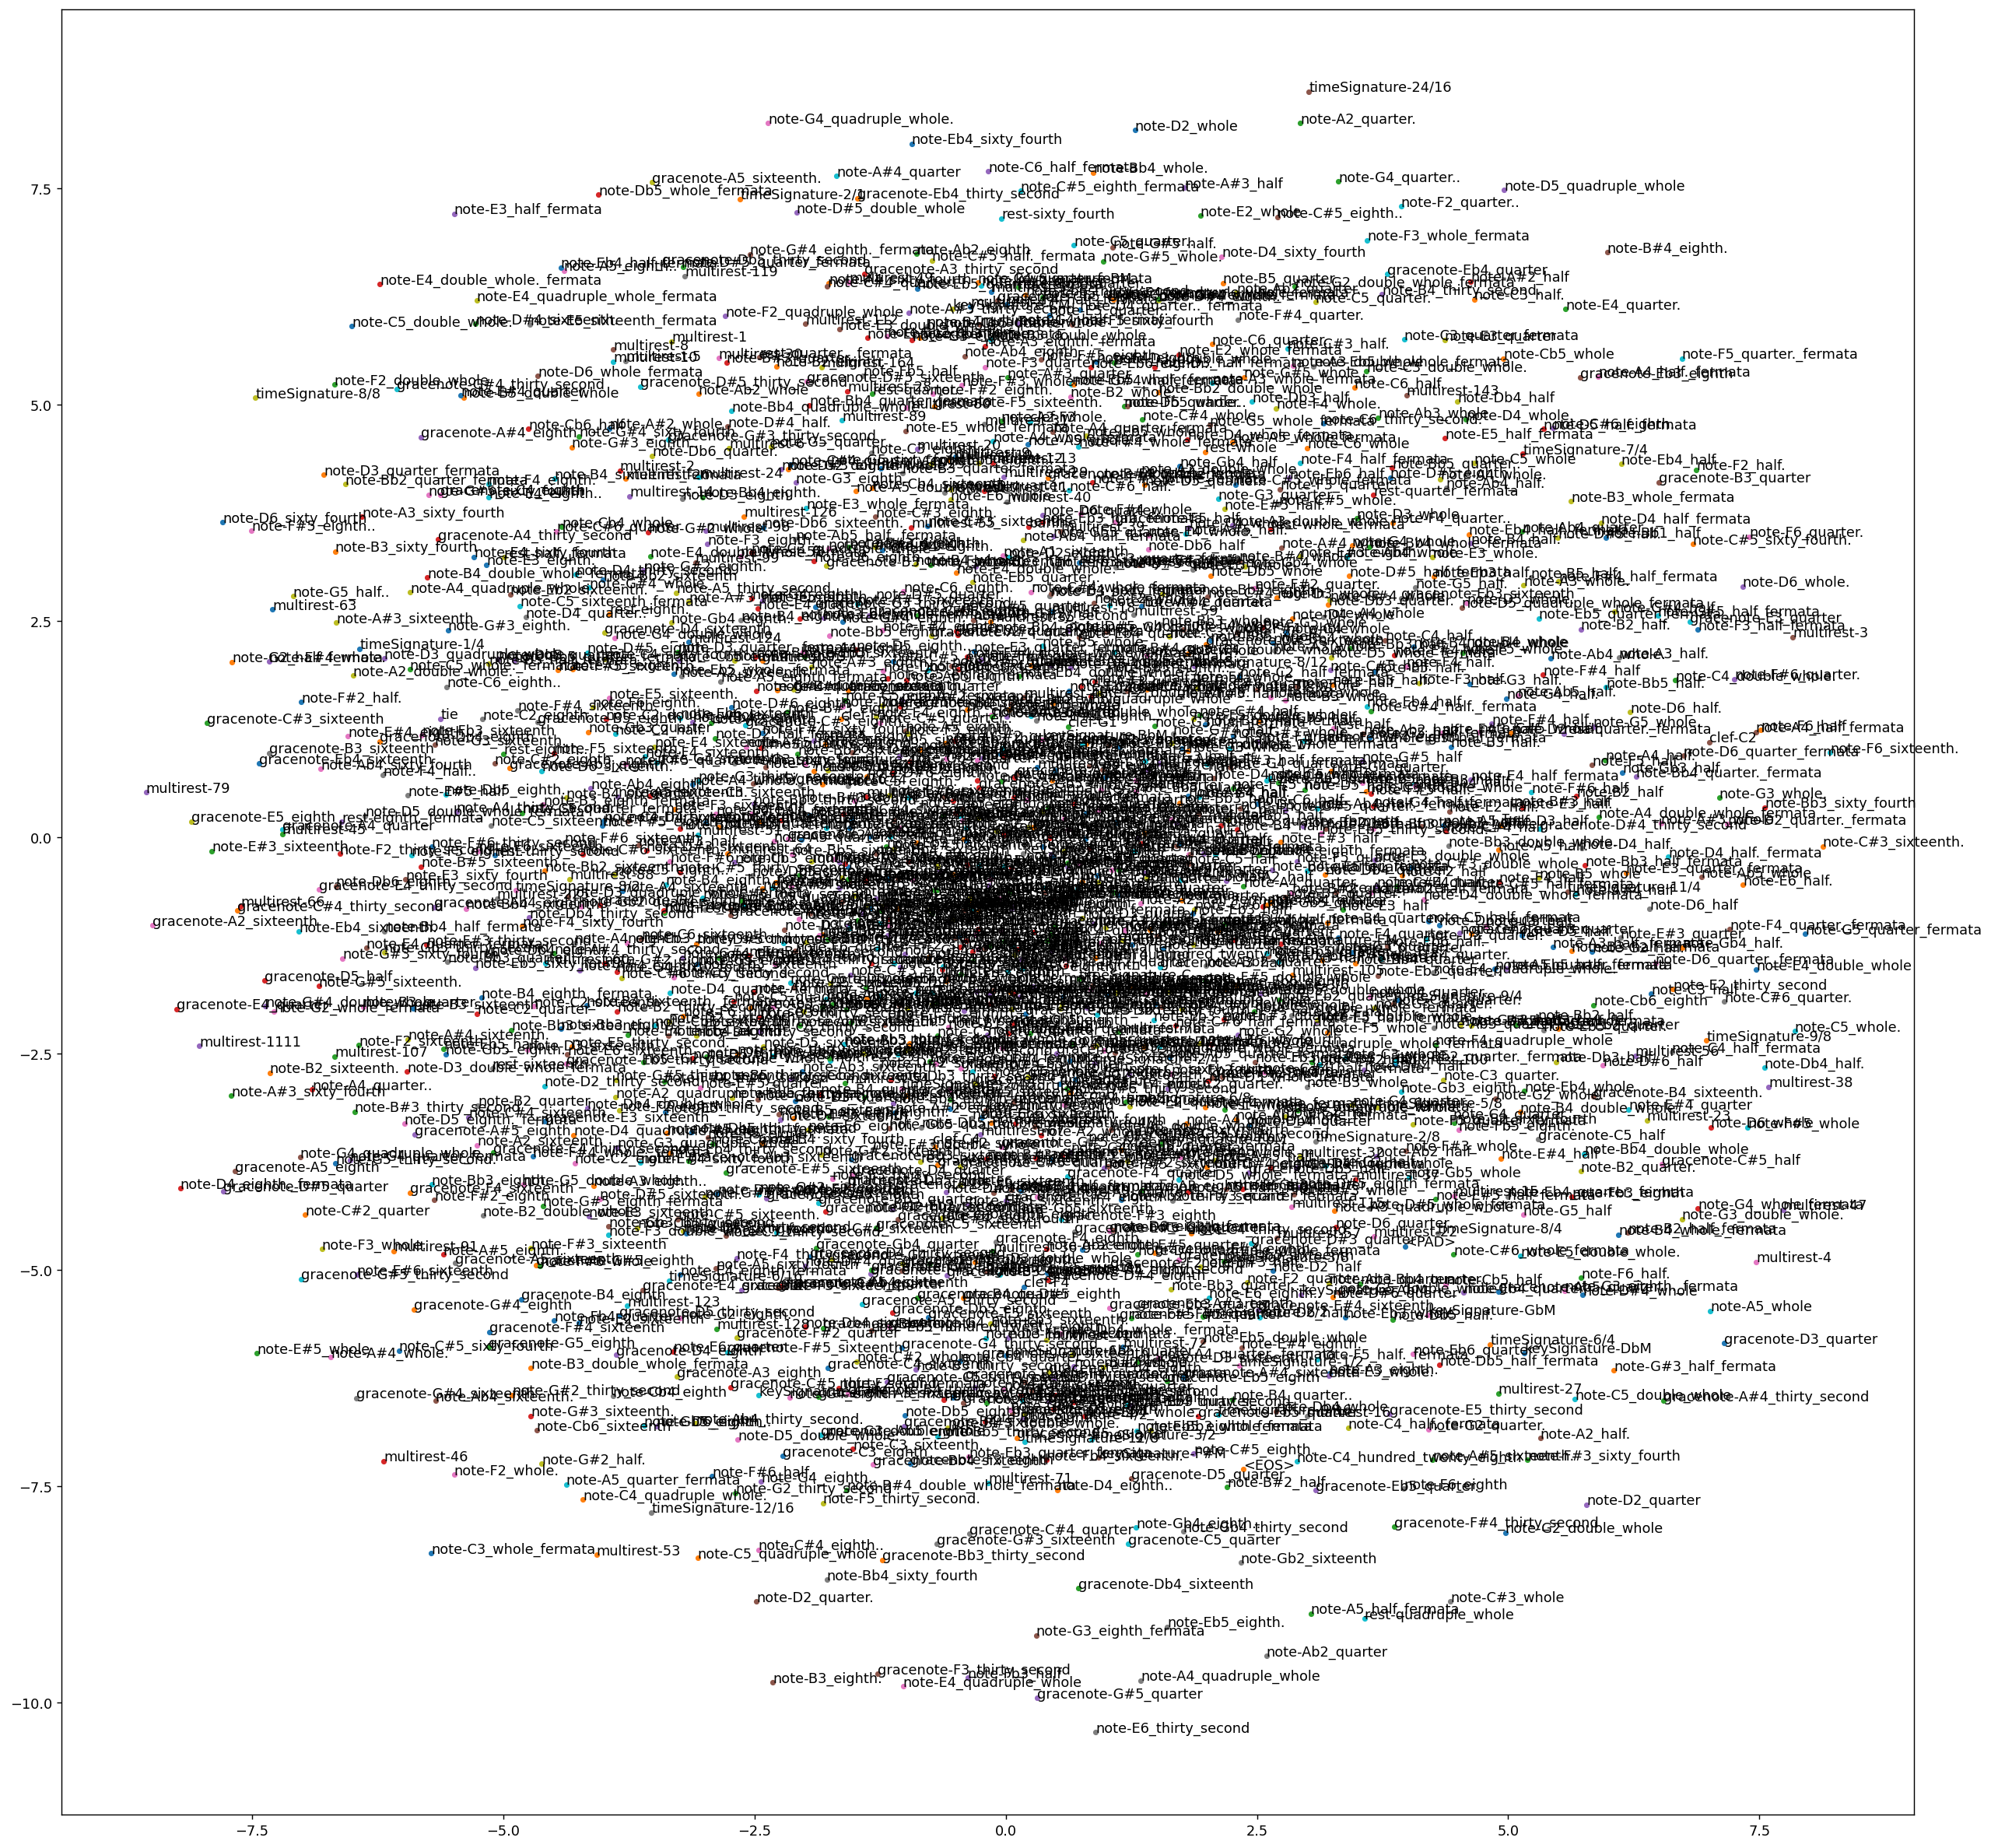

In [103]:
plt.figure(figsize=(24,24), dpi=128)
for i,(x,y) in enumerate(sysEmb):
    plt.plot(x, y, '.')
    plt.text(x,y, dataClass.id2lab2[i])

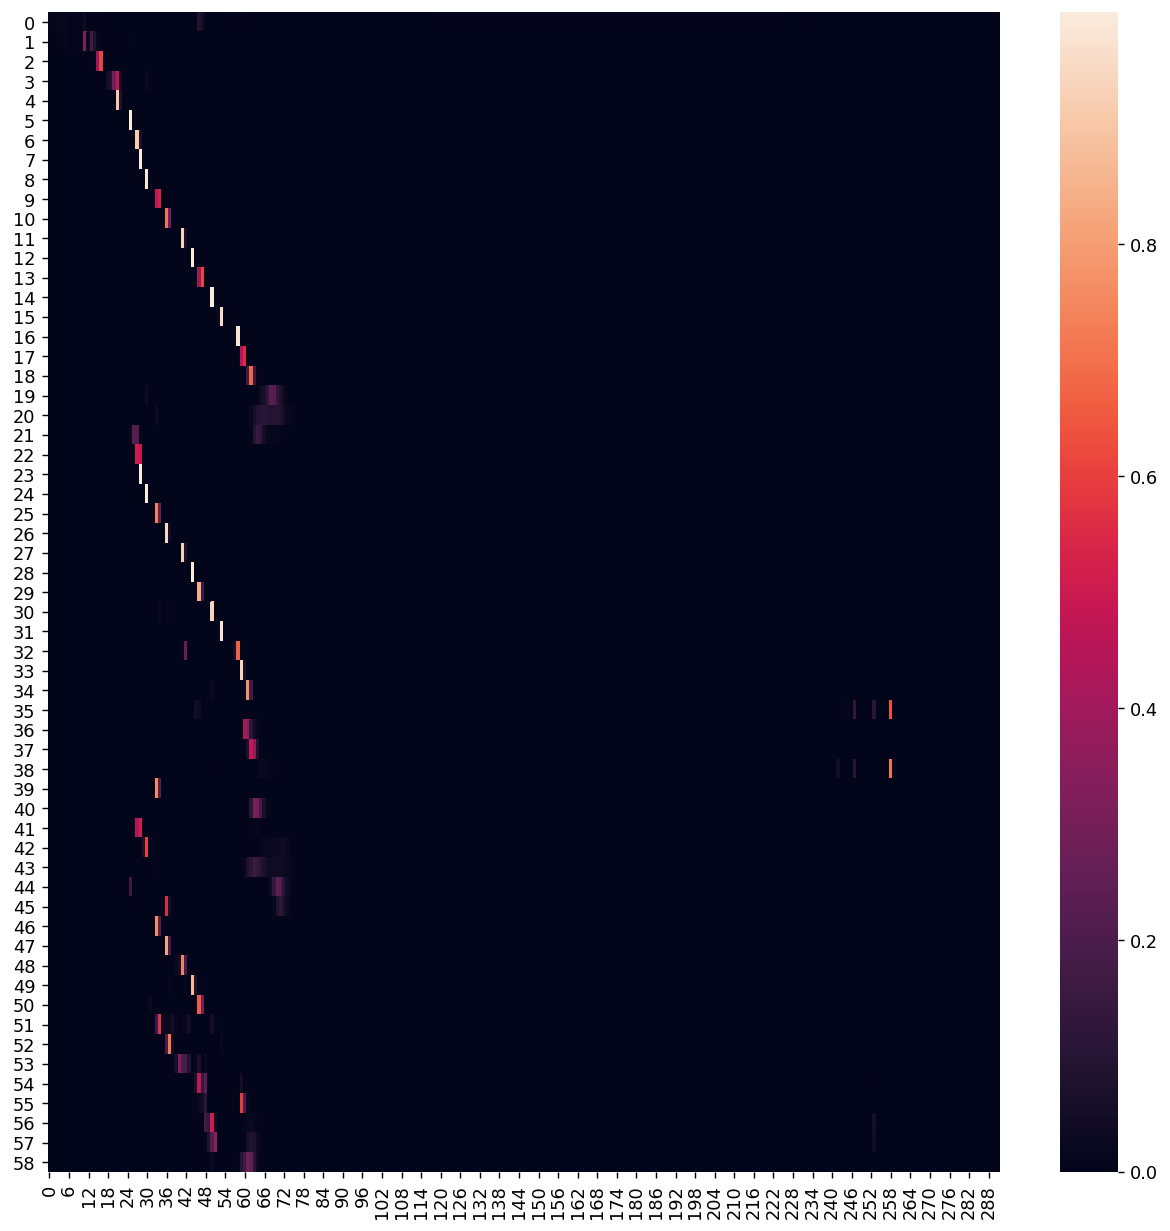

In [105]:
plt.figure(figsize=(12,12), dpi=128)
sns.heatmap(scores[233:].cpu())

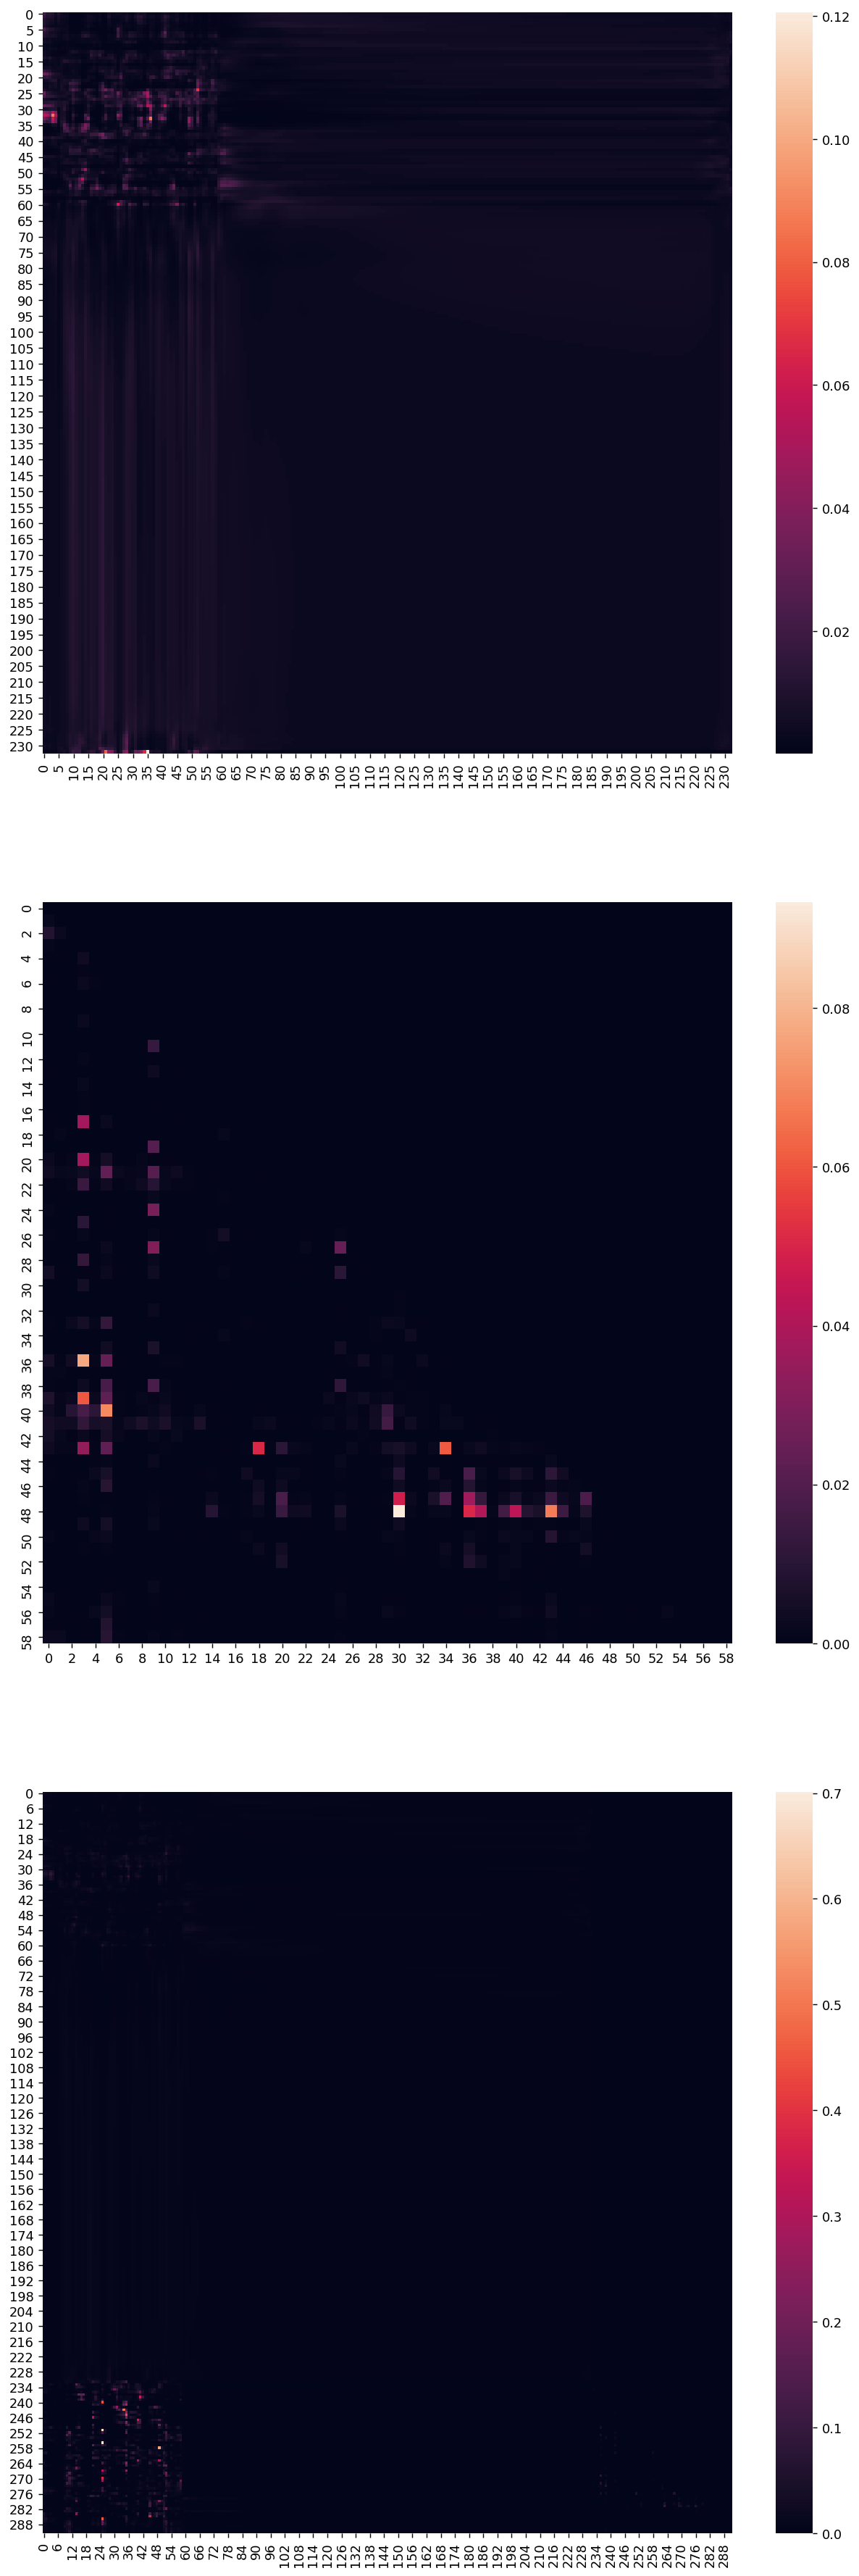

In [106]:
plt.figure(figsize=(12,36), dpi=128)
scores = model.transformer.transformerLayers.transformer0.selfAttn.scores[0][0].detach().cpu()
plt.subplot(3,1,1)
sns.heatmap( scores[:233,:233] )
plt.subplot(3,1,2)
sns.heatmap( scores[233:,233:] )
plt.subplot(3,1,3)
sns.heatmap( scores )

In [ ]:
dataClass.imgArr[dataClass.testIdList[0]]

In [10]:
imgArr,imgLab = dataClass.imgArr[dataClass.testIdList][:2],dataClass.labArr[dataClass.testIdList][:2]

In [11]:
x = torch.tensor(imgArr, device=model.device).transpose(1,2)
y = torch.tensor(imgLab, dtype=torch.long, device=model.device) # => batchSize × seqLen
y = model.symEmbedding(y) # => batchSize × seqLen × feaSize
# x: batchSize × seqLen × feaSize
B,L,C = x.shape
x = torch.cat([x, torch.ones((B,1,C), device=model.device), y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
y = x[:,-model.maxItems-2:-1] # => batchSize × maxItems × feaSize
y = model.fcLinear(y)

In [17]:
dataClass.testIdList[0]

78755

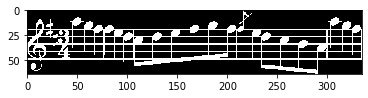

In [10]:
plt.imshow( dataClass.imgs[dataClass.testIdList[1]], cmap='gray' )

In [22]:
[dataClass.id2lab2[i] for i in imgLab[0]]

['clef-C1',
 'keySignature-EbM',
 'timeSignature-2/4',
 'multirest-23',
 'barline',
 'rest-quarter',
 'rest-eighth',
 'note-Bb4_eighth',
 'barline',
 'note-Bb4_quarter.',
 'note-G4_eighth',
 'barline',
 'note-Eb5_quarter.',
 'note-D5_eighth',
 'barline',
 'note-C5_eighth',
 'note-C5_eighth',
 'rest-quarter',
 'barline',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>']

In [12]:
y.argmax(dim=-1)

tensor([[   2,  230, 1752,  266,    1, 1728, 1718,  679,    1,  688, 1600,    1,
         1315, 1019,  824,  824,  824, 1728,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,  224, 1780,  262,    1, 1723, 1728, 1718, 1406,    1,  683, 1742,
            1, 1742, 1019,    1, 1027, 1037, 1455,    1, 1471, 1455, 1723, 1723,
            1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       device='cuda:0')

In [13]:
imgLab

array([[   2,  230, 1752,  266,    1, 1728, 1718,  679,    1,  689, 1600,
           1, 1315, 1019,    1,  824,  824, 1728,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,  224, 1780,  267,    1, 1723, 1728, 1718, 1406,    1,  683,
        1742,  688, 1304, 1019,    1, 1028, 1647, 1455,    1, 1455, 1019,
         688, 1723,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [16]:
model.transformer.transformerLayers.transformer0.selfAttn

SelfAttention_seq2seq(
  (WQ): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (WK): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (WV): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (WO): Linear(in_features=128, out_features=64, bias=True)
)

In [17]:
WQ = model.transformer.transformerLayers.transformer0.selfAttn.WQ
WK = model.transformer.transformerLayers.transformer0.selfAttn.WK
WV = model.transformer.transformerLayers.transformer0.selfAttn.WV
dk = model.transformer.transformerLayers.transformer0.selfAttn.dk
multiNum = model.transformer.transformerLayers.transformer0.selfAttn.multiNum
maxItems = model.transformer.transformerLayers.transformer0.selfAttn.maxItems
WO = model.transformer.transformerLayers.transformer0.selfAttn.WO

In [20]:
scores1[0][0,1472]

tensor([0.0006, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009], device='cuda:6',
       grad_fn=<SelectBackward>)

In [21]:
scores2[0][0,1472]

tensor([0.0006, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009], device='cuda:6',
       grad_fn=<SelectBackward>)

In [18]:
x = torch.tensor(imgArr, device=model.device).transpose(1,2)
y = torch.tensor(imgLab, dtype=torch.long, device=model.device) # => batchSize × seqLen
y = model.symEmbedding(y) # => batchSize × seqLen × feaSize
# x: batchSize × seqLen × feaSize
B,L,C = x.shape
x = torch.cat([x, torch.ones((B,1,C), device=model.device), y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
#x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
#y = x[:,-model.maxItems-1:-1] # => batchSize × maxItems × feaSize
#y = model.fcLinear(y)

queries1 = [WQ[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
keys1    = [WK[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
values1  = [WV[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
scores1  = [torch.bmm(queries1[i], keys1[i].transpose(1,2))/np.sqrt(dk) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × seqLen)

mask = torch.ones(scores1[0].shape, dtype=torch.float32, device=scores1[0].device) # => batchSize × seqLen × seqLen
mask[:,:-(maxItems+1), -(maxItems+1):] = 0
for j in range(maxItems):
    mask[:,-(maxItems+1-j),-(maxItems+1-j):] = 0

for i in range(len(scores1)):
    scores1[i] = F.softmax(scores1[i]*mask, dim=2)

#z1 = [torch.bmm(scores1[i], values1[i]) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
#z1 = WO(torch.cat(z1, dim=2)) # => batchSize × seqLen × feaSize

In [19]:
x = torch.tensor(imgArr, device=model.device).transpose(1,2)
y = torch.tensor(imgLab//2, dtype=torch.long, device=model.device) # => batchSize × seqLen
y = model.symEmbedding(y) # => batchSize × seqLen × feaSize
# x: batchSize × seqLen × feaSize
B,L,C = x.shape
x = torch.cat([x, torch.ones((B,1,C), device=model.device), y], dim=1) # => batchSize × (seqLen+1+maxItems+1) × feaSize
#x,_ = model.transformer(x) # => batchSize × (seqLen+1+maxItems+1) × feaSize
#y = x[:,-model.maxItems-1:-1] # => batchSize × maxItems × feaSize
#y = model.fcLinear(y)

queries2 = [WQ[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
keys2    = [WK[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
values2  = [WV[i](x) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
scores2  = [torch.bmm(queries2[i], keys2[i].transpose(1,2))/np.sqrt(dk) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × seqLen)

mask = torch.ones(scores2[0].shape, dtype=torch.float32, device=scores2[0].device) # => batchSize × seqLen × seqLen
mask[:,:-(maxItems+1), -(maxItems+1):] = 0
for j in range(maxItems):
    mask[:,-(maxItems+1-j),-(maxItems+1-j):] = 0

for i in range(len(scores2)):
    scores2[i] = F.softmax(scores2[i]*mask, dim=2)

#z2 = [torch.bmm(scores2[i], values2[i]) for i in range(multiNum)] # => multiNum*(batchSize × seqLen × dk)
#z2 = WO(torch.cat(z2, dim=2)) # => batchSize × seqLen × feaSize